# Bootstrap Particle Filter

In [1]:
using ForneyLab, LinearAlgebra, Plots;

This demo is inspired by https://www.youtube.com/watch?v=aUkBa1zMKv4, where an aircraft flies over some terrain. We know the height profile of the terrain, but not the exact location of the aircraft. The aircraft is equipped with a height sensor that measures its distance from the terrain. However, measurements are noisy, and there is an uncertainty in aircraft displacement. We are interested in inferring the aircraft position from the noisy measurements.

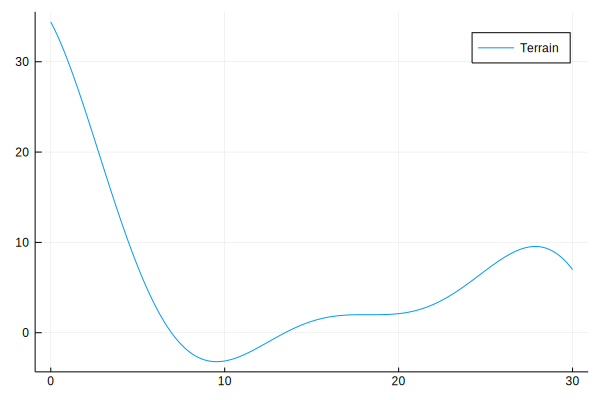

In [2]:
terrain(x) = 0.1*((x-18)^2)*cos(0.25*x) + 2 # Known terrain profile
height(x) = 50.0 - terrain(x) # Distance from terrain

# Visualize the terrain
x_hat = collect(0:0.01:30)
y_hat = terrain.(x_hat)
plot(x_hat, y_hat, label="Terrain")

In [3]:
T = 249 # Time horizon
x_data_0 = 3.0 # Initial position

# Generate some noisy measurements
x_data = Vector{Float64}(undef, T)
y_data = Vector{Float64}(undef, T)
x_data_t_min = x_data_0
for t = 1:T
    x_data[t] = x_data_t_min + 0.1 + 0.1*randn() # Aircraft displacement
    y_data[t] = height(x_data[t]) + 0.1*randn() # Noisy observation
    
    x_data_t_min = x_data[t] # Prepare for next step
end

In [4]:
# Model
g = FactorGraph()

f(x) = x + 0.1 # Noiseless transition model

# State prior
@RV x_t_min ~ SampleList(placeholder(:samples, dims=(200,)),
                         placeholder(:weights, dims=(200,)))

@RV m_x_t ~ Nonlinear{Sampling}(x_t_min, g=f)
@RV x_t ~ GaussianMeanVariance(m_x_t, 0.01) # Noisy transition
@RV h_t ~ Nonlinear{Sampling}(x_t, g=height)
@RV y_t ~ GaussianMeanVariance(h_t, 1.0) # Noisy observation

# Placeholder for data
placeholder(y_t, :y_t);

In [5]:
ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 12567583786336469801 -->
 
 12567583786336469801 
 
 SampleList 
 samplelist_1 
 
<!-- 15453881074619917426 -->
 
 15453881074619917426 
 
 placeholder_weights 
 
<!-- 12567583786336469801--15453881074619917426 -->
 
 12567583786336469801--15453881074619917426 
 
 weights 
 1 out 
 3 w 
 
<!-- 9133291782378568337 -->
 
 9133291782378568337 
 
 placeholder_samples 
 
<!-- 12567583786336469801--9133291782378568337 -->
 
 12567583786336469801--9133291782378568337 
 
 samples 
 1 out 
 2 s 
 
<!-- 4131638813397737254 -->
 
 4131638813397737254 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 11264598827892886007 -->
 
 11264598827892886007 
 
 clamp_1 
 
<!-- 4131638813397737254--11264598827892886007 -->
 
 4131638813397737254--11264598827892886007 
 
 clamp_1 
 1 out 
 3 v 
 
<!-- 14194822032594537460 -->
 
 14194822032594537460 
 
 g{Sampling} 
 nonlinear_1 
 
<!-- 4131638813397737254--14194822032594537460 -->
 
 4131638813397737254--14194822032594537460 
 
 m_x_t 
 1 out 
 2 m 
 
<!-- 5564704325942533961 -->
 
 5564704325942533961 
 
 g{Sampling} 
 nonlinear_2 
 
<!-- 5564704325942533961--4131638813397737254 -->
 
 5564704325942533961--4131638813397737254 
 
 x_t 
 1 out 
 2 in1 
 
<!-- 1907992567527838013 -->
 
 1907992567527838013 
 
 placeholder_y_t 
 
<!-- 4108587852720321442 -->
 
 4108587852720321442 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 1907992567527838013--4108587852720321442 -->
 
 1907992567527838013--4108587852720321442 
 
 y_t 
 1 out 
 1 out 
 
<!-- 3992113422978860717 -->
 
 3992113422978860717 
 
 clamp_2 
 
<!-- 4108587852720321442--5564704325942533961 -->
 
 4108587852720321442--5564704325942533961 
 
 h_t 
 1 out 
 2 m 
 
<!-- 4108587852720321442--3992113422978860717 -->
 
 4108587852720321442--3992113422978860717 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 14194822032594537460--12567583786336469801 -->
 
 14194822032594537460--12567583786336469801 
 
 x_t_min 
 1 out 
 2 in1

In [6]:
algo = messagePassingAlgorithm(x_t) 
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code))
println(source_code)

begin

function init()

messages = Array{Message}(undef, 5)

messages[1] = Message(vague(SampleList))
messages[3] = Message(vague(SampleList))

return messages

end

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 5))

messages[1] = ruleSPSampleListOutNPP(nothing, Message(Multivariate, PointMass, m=data[:samples]), Message(Multivariate, PointMass, m=data[:weights]))
messages[2] = ruleSPNonlinearSOutNM(f, nothing, messages[1])
messages[3] = ruleSPGaussianMeanVarianceOutNSP(nothing, messages[2], Message(Univariate, PointMass, m=0.01))
messages[4] = ruleSPGaussianMeanVarianceMPNP(Message(Univariate, PointMass, m=data[:y_t]), nothing, Message(Univariate, PointMass, m=1.0))
messages[5] = ruleSPNonlinearSIn1MN(height, messages[4], nothing)

marginals[:x_t] = messages[3].dist * messages[5].dist

return marginals

end

end # block


┌ Info: Saved animation to 
│   fn = /home/thijs/Code/ForneyLab/demo/figures/particle_filter.gif
└ @ Plots /home/thijs/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/home/thijs/Code/ForneyLab/demo/figures/particle_filter.gif")
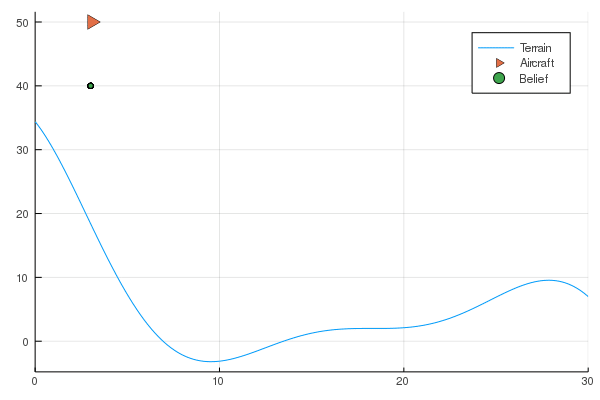

In [7]:
# Define values for prior statistics
sample_vals = rand(1:30,100)
weight_vals = ones(100)/100

sample_list = []
weight_list = []

anim = @animate for t=1:T
    # Prepare data and prior statistics
    data = Dict(:y_t     => y_data[t],
                :samples => sample_vals,
                :weights => weight_vals)
    
    # Execute algorithm
    marginals = step!(data)

    samples = marginals[:x_t].params[:s]
    weights = marginals[:x_t].params[:w]
    
    push!(sample_list, samples)
    push!(weight_list, weights)
    
    plt = plot(x_hat, y_hat, label="Terrain", xlim=(0, 30))
    plot!(plt,(x_data[t], 50), seriestype=:scatter, markershape=:rtriangle, markersize=10, label="Aircraft") # Actual position
    plot!(plt, samples, 40.0.*ones(100), seriestype=:scatter, markersize=250.0.*weights,label="Belief") # Inferred position
    
end

gif(anim, "figures/particle_filter.gif", fps=10)